# Derivation of motion bounds

This document describes how the bounds of an animated object are computed in Embree.

Animation is implemented by specifing transformation matrices and vertex positions for a number of time steps. We will assume that there are only time steps $t_0=0$ and $t_1=1$. For each of these time steps the animation is modelled as a product of three matrices $A=D R S$ where $D$ is a translation matrix, $S$ is an upper triangular matrix and $R$ is a rotation matrix defined using quaternions. The matrices $D$ and $S$ are interpolated linearly for $t\in(0,1)$ and the quaternions are interpolated spherically (see https://en.wikipedia.org/wiki/Slerp). Also, the position of a vertex is specified per time step and interpolated lineraly in between. With this we can write the motion curve of a vertex as

$\Gamma(t, S_0, S_1, Q_0, Q_1, D_0, D_1, p_0, p_1) = \text{lerp}(D_0, D_1, t) \ \text{slerp}(Q_0, Q_1, t) \ \text{lerp}(S_0, S_1, t) \ \text{lerp}(p_0, p_1, t)$

To compute bounds for this curve over the whole time range $[0,1]$ we will evaluate compute the roots of the derivative $\frac{d\Gamma}{dt}$. We will then evaluate $\Gamma$ for the corresponding times and the interval boundaries $t=0, t=1$. This is needed because the roots of the derivative might be outside of $[0,1]$ and the interval boundaries are the extrema in this case.

## Generating Code 

The following code will create an expression for $\Gamma$ using the computer algebra system sympy

In [1]:
%matplotlib notebook
import sympy as sp
import numpy as np
import math

t, theta = sp.symbols("t, theta", real = True)

px0, py0, pz0 = sp.symbols("px0, py0, pz0", real=True) # vertex position at t=0
px1, py1, pz1 = sp.symbols("px1, py1, pz1", real=True) # vertex position at t=1

tx0, ty0, tz0 = sp.symbols("tx0, ty0, tz0", real=True) # translation at t=0
tx1, ty1, tz1 = sp.symbols("tx1, ty1, tz1", real=True) # translation at t=1

qx0, qy0, qz0, qw0 = sp.symbols("qx0, qy0, qz0, qw0", real=True) # quaternion at t=0 
qx1, qy1, qz1, qw1 = sp.symbols("qx1, qy1, qz1, qw1", real=True) # quaternion at t=1

# coefficients for upper triangular matrices
s000, s001, s002, s003, s011, s012, s013, s022, s023 = sp.symbols("s000, s001, s002, s003, s011, s012, s013, s022, s023", real=True)
s100, s101, s102, s103, s111, s112, s113, s122, s123 = sp.symbols("s100, s101, s102, s103, s111, s112, s113, s122, s123", real=True)

# simple linear interpolation wrapper
def lerp(v0,v1,t):
    return v0*(1-t)+v1*t

# custom quaternion to matrix conversion
def to_rotation_matrix(q):
    return sp.Matrix([[q.a*q.a + q.b*q.b - q.c*q.c - q.d*q.d, 2*(q.b*q.c - q.a*q.d),                 2*(q.b*q.d + q.a*q.c),                 0], 
                      [2*(q.b*q.c + q.a*q.d),                 q.a*q.a - q.b*q.b + q.c*q.c - q.d*q.d, 2*(q.c*q.d - q.a*q.b),                 0], 
                      [2*(q.b*q.d - q.a*q.c),                 2*(q.c*q.d + q.a*q.b),                 q.a*q.a - q.b*q.b - q.c*q.c + q.d*q.d, 0],
                      [0,                                     0,                                     0,                                     1]])

q0 = sp.Quaternion(qw0, qx0, qy0, qz0)
q1 = sp.Quaternion(qw1, qx1, qy1, qz1)

# assuming that q1 is qperp = normalize(q1-q0*cosTheta), where cosTheta=dot(q0, q1) and theta = acos(cosTheta).
# this simplifies the terms of the symbolic expressions later
qt = q0 * sp.cos(t*theta) + q1 * sp.sin(t*theta)

S0 = sp.Matrix([[s000, s001, s002, s003],
                [   0, s011, s012, s013],
                [   0,    0, s022, s023],
                [   0,    0,    0,    1]])
S1 = sp.Matrix([[s100, s101, s102, s103],
                [   0, s111, s112, s113],
                [   0,    0, s122, s123],
                [   0,    0,    0,    1]])
D0 = sp.Matrix([[1, 0, 0, tx0],
                [0, 1, 0, ty0],
                [0, 0, 1, tz0],
                [0, 0, 0,  1]])
D1 = sp.Matrix([[1, 0, 0, tx1],
                [0, 1, 0, ty1],
                [0, 0, 1, tz1],
                [0, 0, 0,  1]])
p0 = sp.Matrix([px0, py0, pz0, 1])
p1 = sp.Matrix([px1, py1, pz1, 1])

Gamma = lerp(D0, D1, t)*to_rotation_matrix(qt)*lerp(S0, S1, t)*lerp(p0, p1, t)

To bound this motion curve we will follow a similar approach as PBRT (see http://www.pbr-book.org/3ed-2018/Geometry_and_Transformations/Animating_Transformations.html) and write the derivative of $\Gamma$ in a form that
can be quickly evaluated for varying times $t$ and vertex coordinates $p_0, p_1$. This form will be

\begin{align}
\frac{d \Gamma(t, ..., p_0, p_1)}{dt} &= c_0(..., p_0,p_1) + c_1(..., p_0,p_1) t\\
&+ (c_2(..., p_0,p_1) + c_3(..., p_0,p_1) t + c_4(..., p_0,p_1) t^2) \cos(2t\theta) \\
&+ (c_5(..., p_0,p_1) + c_6(..., p_0,p_1) t + c_7(..., p_0,p_1) t^2) \sin(2t\theta)
\end{align}

where $\theta=\cos^{-1}(Q_0 \cdot Q_1)$ and the coefficients $c_i$ are of the form

\begin{align}
c_i(...,p_0, p_1) = k_0(...) + (k_1(...), k_2(...), k_3(...))^T p_0 + (k_4(...), k_5(...), k_6(...))^T p_1
\end{align}

Due to the limited functionality of sympy we will do this decomposition for each dimension $x$, $y$, and $z$ seperately. Therefore there will be $168$ real-valued coefficients $k_j$. In the following we will derive expressions for all of these coefficients depending only on the input parameters of $S_i$, $Q_i$, and $D_i$. 

In [2]:
def getTerms(map, key):
    if key in map.keys():
        return map[key]
    return 0

C = sp.Matrix(np.empty(8))   # 8 coefficients
K = sp.Matrix(np.empty(7))   # 7 inputs
A = sp.Matrix(np.empty(8*7*3)) # 8 coefficients, 7 inputs (1, px0, py0, pz0, px1, py1, pz1), 3 dimensions (x, y, z)
dGamma = sp.diff(Gamma, t)

# loop over dimensions (x, y, z)
for dim in range(3):
    dm = sp.expand(dGamma[dim])
    dm = dm.subs(sp.sin(t*theta)*sp.sin(t*theta),(1-sp.cos(2*t*theta))/2) # remove sin(t*theta)^2
    dm = dm.subs(sp.cos(t*theta)*sp.cos(t*theta),(1+sp.cos(2*t*theta))/2) # remove cos(t*theta)^2
    dm = dm.subs(sp.sin(t*theta)*sp.cos(t*theta),sp.sin(2*t*theta)/2)     # remove sin(t*theta)*cos(t*theta)
    dm = sp.expand(dm)
    
    # group all terms in the form a + b * cos(2*t*theta) + c * sin(2*t*theta)
    dm_cos_sin = sp.collect(dm, (sp.cos(2*t*theta), sp.sin(2*t*theta)), evaluate=False)

    # get the terms
    coeff_cos   = getTerms(dm_cos_sin, sp.cos(2*t*theta))
    coeff_sin   = getTerms(dm_cos_sin, sp.sin(2*t*theta))
    coeff_const = getTerms(dm_cos_sin, 1)

    # group the term in the form a + b * t 
    coeff_const_t = sp.collect(coeff_const, t, evaluate=False)
    C[0] = getTerms(coeff_const_t, 1)
    C[1] = getTerms(coeff_const_t, t)

    # group the term in the form a + b * t + c * t^2 
    coeff_cos_t = sp.collect(coeff_cos, t, evaluate=False)
    C[2] = getTerms(coeff_cos_t, 1)
    C[3] = getTerms(coeff_cos_t, t)
    C[4] = getTerms(coeff_cos_t, t*t)

    # group the term in the form a + b * t + c * t^2 
    coeff_sin_t = sp.collect(coeff_sin, t, evaluate=False)
    C[5] = getTerms(coeff_sin_t, 1)
    C[6] = getTerms(coeff_sin_t, t)
    C[7] = getTerms(coeff_sin_t, t*t)

    for c in range(8):
        kc = sp.collect(C[c], (px0, py0, pz0, px1, py1, pz1), evaluate=False)
        K[0] = getTerms(kc, 1)
        K[1] = getTerms(kc, px0)
        K[2] = getTerms(kc, py0)
        K[3] = getTerms(kc, pz0)
        K[4] = getTerms(kc, px1)
        K[5] = getTerms(kc, py1)
        K[6] = getTerms(kc, pz1)

        for k in range(7):
            K[k] = sp.expand(K[k])
            K[k] = K[k].subs(qw0*qw0, 1-qx0*qx0-qy0*qy0-qz0*qz0) # clean up substitutions
            K[k] = K[k].subs(qw1*qw1, 1-qx1*qx1-qy1*qy1-qz1*qz1) # clean up substitutions
            K[k] = sp.simplify(K[k])
            A[8*7*dim + c*7 + k] = K[k]

The coefficents look all something like the following and are all independent of $t$ and $p_0,p_1$

In [3]:
A[128]

-2*qw0*qx0*s011 + qw0*qx0*s111 + 2*qw0*qx1*s011*theta + 2*qw0*qy0*s001 - qw0*qy0*s101 - 2*qw0*qy1*s001*theta + 2*qw1*qx0*s011*theta + 2*qw1*qx1*s011 - qw1*qx1*s111 - 2*qw1*qy0*s001*theta - 2*qw1*qy1*s001 + qw1*qy1*s101 - 2*qx0*qz0*s001 + qx0*qz0*s101 + 2*qx0*qz1*s001*theta + 2*qx1*qz0*s001*theta + 2*qx1*qz1*s001 - qx1*qz1*s101 - 2*qy0*qz0*s011 + qy0*qz0*s111 + 2*qy0*qz1*s011*theta + 2*qy1*qz0*s011*theta + 2*qy1*qz1*s011 - qy1*qz1*s111

In the following we will generate a C function that takes the input parameters and computes all coefficients $k_j$. It will generate two files (in the directory of this notebook) ````motion_derivative_coefficents.h```` and ````motion_derivative_coefficients.c```` which contains only the definition and declaration of the function computing the coefficients $k_j$. The signature of the function will be

````void motion_derivative_coefficients(float* p, float* coeff);````

where ````p```` are all 33 parameters (see the list at the creation of````param_map```` below) and ````coeffs```` will be the 168 coefficients computed inside the function

In [4]:
from sympy.utilities.codegen import codegen, default_datatypes
from sympy.codegen.ast import real, float32
from sympy.printing.c import C99CodePrinter
printer = C99CodePrinter()

# custom code printer that will not generate such nonesene as x^2 -> pow(x, 2)
class CustomCodePrinter(C99CodePrinter):
    def _print_Pow(self, expr):
        if expr.exp.is_integer and expr.exp > 0 and expr.exp < 5:
            return '*'.join([self._print(expr.base) for i in range(expr.exp)])
        else:
            return super()._print_Pow(expr)

customprinter = CustomCodePrinter()
customprinter.type_aliases[real] = float32 # cosf instead of cos
default_datatypes["float"].cname = "float" # float instead of double
params = [
    theta,
    tx0, ty0, tz0,
    tx1, ty1, tz1,
    qw0, qx0, qy0, qz0,
    qw1, qx1, qy1, qz1,
    s000, s001, s002, s003, s011, s012, s013, s022, s023,
    s100, s101, s102, s103, s111, s112, s113, s122, s123]
R = sp.MatrixSymbol("coeff", A.shape[0], A.shape[1])
P = sp.MatrixSymbol('p', len(params), 1)
param_map = dict(zip(params, P))
B = A.xreplace(param_map)
codegen(('motion_derivative_coefficients', sp.Eq(R,B)), language='c', printer=customprinter, prefix='motion_derivative_coefficients', to_files=True)

## Testing Code

Next, we will use cython to compile the generated code and create a python wrapper around it. This way we can make sure that everything works as we want.

In [6]:
%load_ext cython

In [7]:
%%writefile cy_motion_derivative_coefficients.pyxbld
import numpy

#            module name specified by `%%cython_pyximport` magic
#            |        just `modname + ".pyx"`
#            |        |
def make_ext(modname, pyxfilename):
    from setuptools.extension import Extension
    return Extension(modname,
                     sources=[pyxfilename, 'motion_derivative_coefficients.c'],
                     include_dirs=['.', numpy.get_include()])

Overwriting cy_motion_derivative_coefficients.pyxbld


In [8]:
%%cython_pyximport cy_motion_derivative_coefficients

import numpy as np # we have to import np here again
cimport numpy as cnp # cimport gives us access to NumPy's C API

# here we just replicate the function signature from the header
cdef extern from "motion_derivative_coefficients.h":
    void motion_derivative_coefficients(float *params, float *result)

# here is the "wrapper"
def cy_motion_derivative_coefficients(cnp.ndarray[cnp.float32_t, ndim=1] params, size):
    # preallocate our output array
    cdef cnp.ndarray[cnp.float32_t, ndim=1] result = np.empty(size, dtype='float32')
    # now call the C function
    motion_derivative_coefficients(<float *> params.data, <float *> result.data)
    # return the result
    return result

C:\Users\freibold.GER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\freibold.GER\OneDrive - Intel Corporation\MotionCurve\cy_motion_derivative_coefficients.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We define some test data to verify the bounds we compute. Below, we define a triangle with vertex positions $t_0$ at $t=0$ and positions $t_1$ at $t=1$ that will be transformed by the matrices.

In [9]:
# enable/disable nonlinear interpolation
slerpMode = True

Q0 = sp.Quaternion.from_axis_angle((0, 1, 0), 0)
Q1 = sp.Quaternion.from_axis_angle((0, 0, 1), math.pi) #pi
Q0 = Q0.normalize() 
Q1 = Q1.normalize()

cosTheta = Q0.a*Q1.a + Q0.b*Q1.b + Q0.c*Q1.c + Q0.d*Q1.d
Qperp = Q1
if (cosTheta < 0.995):
    Qperp = Q1-Q0*cosTheta
    Qperp = Qperp.normalize()
S0 = np.array([[ 1.0,  0.0,  0.0,  0.0],
               [   0,  1.0,  0.0,  0.0],
               [   0,    0,  1.0,  0.0],
               [   0,    0,    0,    1]])
S1 = np.array([[ 2.0, -0.5,  1.0,  0.1],
               [   0,  2.0, -0.5, -0.5],
               [   0,    0,  2.0,  0.3],
               [   0,    0,    0,    1]])
D0 = np.array([[1, 0, 0,  0.1],
               [0, 1, 0,  0.2],
               [0, 0, 1,  0.3],
               [0, 0, 0,  1  ]])
D1 = np.array([[1, 0, 0, -0.1],
               [0, 1, 0, -0.2],
               [0, 0, 1, -0.3],
               [0, 0, 0,  1  ]])

# for linear motion
A0 = np.array(D0*to_rotation_matrix(Q0)*S0).astype(float)
A1 = np.array(D1*to_rotation_matrix(Q1)*S1).astype(float)

t0 = np.array([[-0.1,  0.0, -0.1,  1.0], [ 0.1, 0.0, -0.1,  1.0], [ 0.0, -0.1,  0.1,  1.0]])
t1 = np.array([[-0.1,  1.0,  1.1,  1.0], [-0.1, 1.0,  0.9,  1.0], [ 0.1,  1.1,  1.0,  1.0]])


A0 = np.array([[ 2.0,  0.1, -0.2,  0.5],
               [   0,  2.0,  0.2,  0.0],
               [   0,    0,  2.0, -0.5],
               [   0,    0,    0,    1]])
A1 = np.array([[   0,  0.0,  1.0,  0.0],
               [   0,  1.0,  0.0,  0.0],
               [-1.0,    0,  0.0,  0.0],
               [   0,    0,    0,    1]]) 

t0 = np.array([[-0.1,  0.0, -0.1,  1.0], [ 0.1,  0.0, -0.1,  1.0], [ 0.0, -0.1,  0.1,  1.0]])
t1 = np.array([[-0.1,  2.0,  2.2,  1.0], [-0.2,  2.0,  1.8,  1.0], [ 0.2,  2.2,  2.0,  1.0]])

A0 = np.array([[ 1.0,  0.0,  0.0,  0.0],
               [   0,  1.0,  0.0,  0.0],
               [   0,    0,  1.0,  0.0],
               [   0,    0,    0,    1]])
A1 = np.array([[   0,  1.0,  0.0,  0.0],
               [-1.0,  0.0,  0.0,  0.0],
               [ 0.0,    0,  1.0,  0.0],
               [   0,    0,    0,    1]])

t0 = np.array([[-0.1,  0.0, -0.1,  1.0], [ 0.1,  0.0, -0.1,  1.0], [ 0.0, 0.0,  0.1,  1.0]])
t1 = np.array([[-0.1,  2.0, -0.1,  1.0], [ 0.1,  2.0, -0.1,  1.0], [ 0.0, 2.0,  0.1,  1.0]])

We use our generated code to compute the coefficients for this test input:

In [10]:
params = np.array([
    math.acos(cosTheta), 
    D0[0][3], D0[1][3], D0[2][3],
    D1[0][3], D1[1][3], D1[2][3],
    Q0.a,    Q0.b,    Q0.c,    Q0.d,
    Qperp.a, Qperp.b, Qperp.c, Qperp.d,
    S0[0][0], S0[0][1], S0[0][2], S0[0][3],
              S0[1][1], S0[1][2], S0[1][3],
                        S0[2][2], S0[2][3],
    S1[0][0], S1[0][1], S1[0][2], S1[0][3],
              S1[1][1], S1[1][2], S1[1][3],
                        S1[2][2], S1[2][3]],
    dtype='float32')
coeffs = cy_motion_derivative_coefficients(params, 3*8*7)

Next, we define a function to evaluate a dimension of the motion derivative using the coefficents and vertex positions $p_0$ and $p_1$. 

In [12]:
def evalK(A, dim, c, p0, p1):
    res = 0
    p = [1, p0[0], p0[1], p0[2], p1[0], p1[1], p1[2]]
    for k in range(7):
        res += A[8*7*dim + c*7 + k] * p[k]
    return res

def motion_derivative(t, A, theta, dim, p0, p1):
    c0 = evalK(A, dim, 0, p0, p1)
    c1 = evalK(A, dim, 1, p0, p1)
    c2 = evalK(A, dim, 2, p0, p1)
    c3 = evalK(A, dim, 3, p0, p1)
    c4 = evalK(A, dim, 4, p0, p1)
    c5 = evalK(A, dim, 5, p0, p1)
    c6 = evalK(A, dim, 6, p0, p1)
    c7 = evalK(A, dim, 7, p0, p1)
    return c0 + c1 * t + (c2 + c3 * t + c4 * t**2) * np.cos(2*t*theta) + (c5 + c6 * t + c7 * t**2) * np.sin(2*t*theta)

def motion_derivative_bbox(t, A, theta, dim, p0, p1, b0, b1):
    return motion_derivative(t, A, theta, dim, p0, p1) - (b1 - b0)

for i in range(3):
    print(motion_derivative(0.25, coeffs, math.acos(cosTheta), i, t0[0], t1[0]))
    
from scipy import optimize
num_splits = 10
for dim in range(3):
    for i in range(num_splits):    
        tt0 = (i+0.0)/10.0
        tt1 = (i+1.0)/10.0
        tts = (i+0.5)/10.0
        ttt = optimize.fsolve(motion_derivative, tts, 
                                args=(coeffs, math.acos(cosTheta), dim, t0[0], t1[0]), full_output=True)
        if ttt[2] == 1:
            for t in ttt[0]:
                if (t < tt1 and t >= tt0):
                    print("root (dim = {}): {}".format(dim, t))

-3.1493549551856974
-0.5761509417289041
-0.40000001192092893
root (dim = 0): 0.6148657269556785
root (dim = 1): 0.20693675142228748


<IPython.core.display.Javascript object>


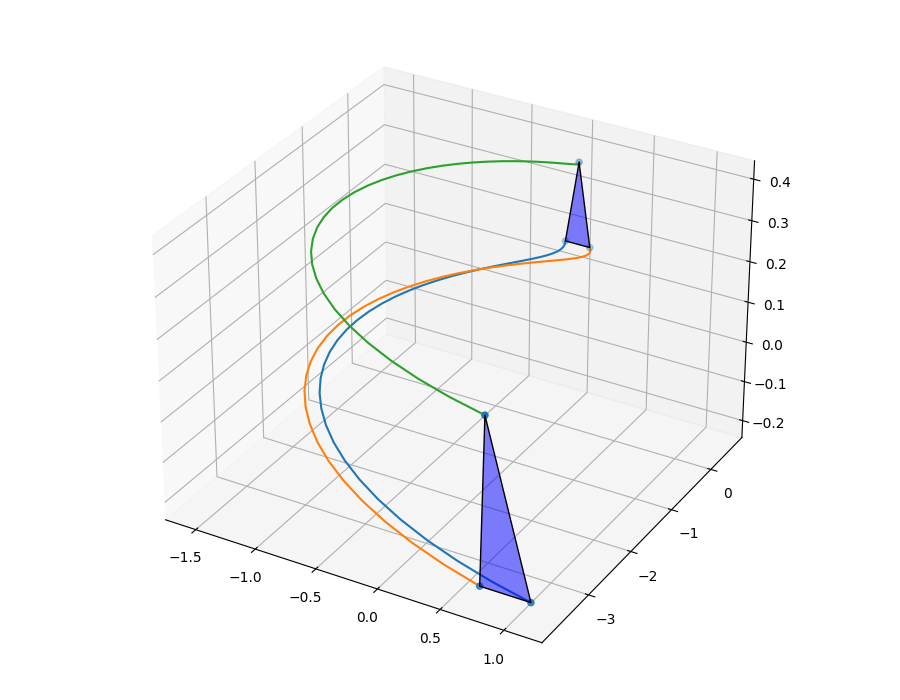

In [13]:
# a simple bbox class for more readable code (see bbox.py)
from bbox import *

def lerpBBox(bbox0, bbox1, t):
    bboxt = BBox(lerp(bbox0.bbmin, bbox1.bbmin, t), lerp(bbox0.bbmax, bbox1.bbmax, t))
    return bboxt

# spherical interpolation of two (sympy) quaternions q0 and q1 for time t
def slerp(q0, q1, t):
    cosTheta = q0.a * q1.a + q0.b * q1.b + q0.c * q1.c + q0.d * q1.d
    if cosTheta > 0.9995:
        q = (1-t) * q0 + t * q1
        return q.normalize()
    theta = math.acos(cosTheta)
    return 1.0/math.sin(theta) * (q0 * math.sin((1-t)*theta) + q1 * math.sin(t*theta))

# this evaluates the position of a transformed point with startpoint p0 and endpoint p1
# using the given DRS transformation matrices for a time point t
def motionSlerp(S0, S1, Q0, Q1, D0, D1, p0, p1, t):
    D = lerp(D0, D1, t)
    S = lerp(S0, S1, t)
    Q = slerp(Q0, Q1, t)
    R = to_rotation_matrix(Q)
    p = lerp(p0, p1, t)
    r = D*R*S*sp.Matrix([p[0], p[1], p[2], p[3]])
    return [float(r[0]), float(r[1]), float(r[2]), float(r[3])]

def motionLerp(A0, A1, p0, p1, t):
    A = lerp(A0, A1, t)
    p = lerp(p0, p1, t)
    r = A.dot(p)
    return [float(r[0]), float(r[1]), float(r[2]), float(r[3])]

def motion(p0, p1, t):
    if slerpMode:
        return motionSlerp(S0, S1, Q0, Q1, D0, D1, p0, p1, t)
    else:
        return motionLerp(A0, A1, p0, p1, t)

times = np.linspace(0.0, 1.0, 40)
motion_vertices = np.array([[motion(t0[i], t1[i], t) for t in times] for i in range(3)]) 

# triangle vertices and faces
tv = np.array([motion(t0[0], t1[0], 0), motion(t0[1], t1[1], 0), motion(t0[2], t1[2], 0),
               motion(t0[0], t1[0], 1), motion(t0[1], t1[1], 1), motion(t0[2], t1[2], 1)])
tf = [[tv[0][:3], tv[2][:3], tv[1][:3]], [tv[3][:3], tv[5][:3], tv[4][:3]]]

#plotting
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for i in range(3):
    ax.plot(motion_vertices[i][:,0], motion_vertices[i][:,1], motion_vertices[i][:,2])
ax.scatter3D(tv[:,0], tv[:,1], tv[:,2])
ax.add_collection3d(Poly3DCollection(tf, linewidth=1, edgecolors='black', facecolor=(0.0, 0.0, 1.0, 0.5)))
plt.tight_layout()
plt.show()

In [14]:
from scipy import optimize
def getRoots(dim, p0, p1, bbox0, bbox1):
    # fsolve returns only one root. so we will call it for many starting points x0=[0, 0.1, ..., 0.9, 1.0]
    # and hope that we find all roots
    result = np.array([])
    num_splits = 10
    for i in range(num_splits):    
        t0 = (i+0.0)/10.0
        t1 = (i+1.0)/10.0
        ts = (i+0.5)/10.0
        tt = optimize.fsolve(motion_derivative_bbox, ts, 
                             args=(coeffs, math.acos(cosTheta), dim, p0, p1, bbox0.bbmin[dim], bbox1.bbmin[dim]))
        for t in tt:
            if (t < t1 and t >= t0):
                result = np.append(result, t)
        tt = optimize.fsolve(motion_derivative_bbox, ts, 
                             args=(coeffs, math.acos(cosTheta), dim, p0, p1, bbox0.bbmax[dim], bbox1.bbmax[dim]))
        for t in tt:
            if (t < t1 and t >= t0):
                result = np.append(result, t)
    return result

def extendSlerp(p0, p1, bbox0, bbox1):
     for dim in range(3):    
        roots = getRoots(dim, p0, p1, bbox0, bbox1)
        for t in roots:
            pt = motion(p0, p1, t)
            bboxt = lerpBBox(bbox0, bbox1, t)
            bbox0.bbmax[dim] = bbox0.bbmax[dim] + max(0.0, pt[dim] - bboxt.bbmax[dim])
            bbox1.bbmax[dim] = bbox1.bbmax[dim] + max(0.0, pt[dim] - bboxt.bbmax[dim])
            bbox0.bbmin[dim] = bbox0.bbmin[dim] + min(0.0, pt[dim] - bboxt.bbmin[dim])
            bbox1.bbmin[dim] = bbox1.bbmin[dim] + min(0.0, pt[dim] - bboxt.bbmin[dim])

def extendLerp(p0, p1, bbox0, bbox1):
    denom = 2.0 * (A0-A1).dot(p0-p1)
    nom_min = 2.0 * A0.dot(p0) - A0.dot(p1) - A1.dot(p0) + (bbox1.bbmin - bbox0.bbmin)
    nom_max = 2.0 * A0.dot(p0) - A0.dot(p1) - A1.dot(p0) + (bbox1.bbmax - bbox0.bbmax)
    print('bbox0', bbox0)
    print('bbox1', bbox1)
    print('p0', p0)
    print('p1', p1)
    print('nom_lower', nom_min[0], nom_min[1], nom_min[2])
    print('nom_upper', nom_max[0], nom_max[1], nom_max[2])
    for dim in range(3):
        if (abs(denom[dim]) > 0):
            t = nom_min[dim] / denom[dim]
            if (t <= 1 and t >= 0):
                pt = motionLerp(A0, A1, p0, p1, t)
                bboxt = lerpBBox(bbox0, bbox1, t)
                print('extend lower', t, ', dim', dim, ', delta', min(0.0, pt[dim] - bboxt.bbmin[dim]))
                bbox0.bbmin[dim] = bbox0.bbmin[dim] + min(0.0, pt[dim] - bboxt.bbmin[dim])
                bbox1.bbmin[dim] = bbox1.bbmin[dim] + min(0.0, pt[dim] - bboxt.bbmin[dim])
            t = nom_max[dim] / denom[dim]
            if (t <= 1 and t >= 0):
                pt = motionLerp(A0, A1, p0, p1, t)
                bboxt = lerpBBox(bbox0, bbox1, t)
                print('extend upper', t, ', dim', dim, ', delta', max(0.0, pt[dim] - bboxt.bbmax[dim]))
                bbox0.bbmax[dim] = bbox0.bbmax[dim] + max(0.0, pt[dim] - bboxt.bbmax[dim])
                bbox1.bbmax[dim] = bbox1.bbmax[dim] + max(0.0, pt[dim] - bboxt.bbmax[dim])
    
def extend(p0, p1, bbox0, bbox1):
    if slerpMode:
        extendSlerp(p0, p1, bbox0, bbox1)
    else:
        extendLerp(p0, p1, bbox0, bbox1)

In [15]:
def xfmBounds(bounds, time):
    corners = bounds.getCorners()
    bbox = BBox()
    for c in corners:
        bbox.extend(motion(c, c, time))
    return bbox

obbox0 = BBox()
obbox1 = BBox()
for i in range(3):
    obbox0.extend(t0[i])
    obbox1.extend(t1[i])
    
bbox0 = xfmBounds(obbox0, 0)
bbox1 = xfmBounds(obbox1, 1)

cobbox0 = obbox0.getCorners()
cobbox1 = obbox1.getCorners()
for c in range(8):
    c0 = cobbox0[c]
    c1 = cobbox1[c]
    extend(c0, c1, bbox0, bbox1)
    
print('bbox0', bbox0)
print('bbox1', bbox1)


C:\Users\freibold.GER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\freibold.GER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


bbox0 BBox
    [-1.90447086  0.16280211  0.2         1.        ]
    [0.2        1.95023892 0.4        1.        ]
bbox1 BBox
    [-1.40447086 -3.78719789 -0.2         1.        ]
    [ 1.1        -1.89976108  0.2         1.        ]


<IPython.core.display.Javascript object>


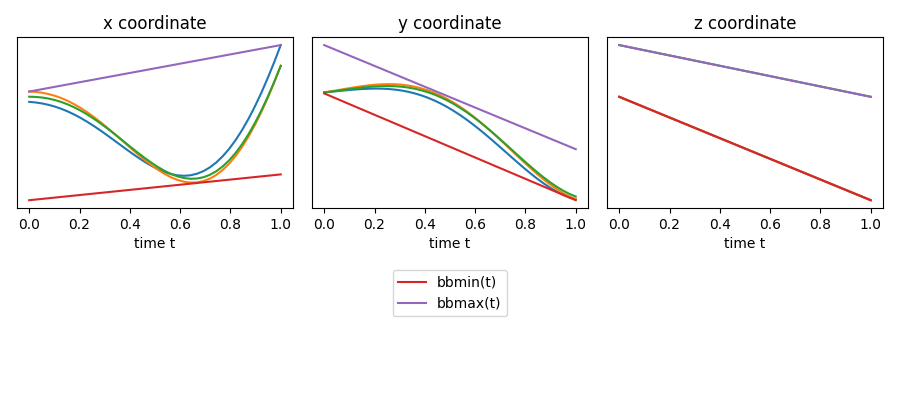

In [16]:
labels = ['x coordinate', 'y coordinate', 'z coordinate']
fig = plt.figure(figsize=(9, 4))
for i in range(0,3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_xlabel("time t")
    ax.set_title(labels[i])
    ax.set_yticks([])
    for j in range(3):
        ax.plot(times, motion_vertices[j][:,i])
    ax.plot(times, [lerp(bbox0.bbmin[i], bbox1.bbmin[i], x)  for x in times], label="bbmin(t)")
    ax.plot(times, [lerp(bbox0.bbmax[i], bbox1.bbmax[i], x) for x in times], label="bbmax(t)")
    if i == 1:
        ax.legend(loc='center', bbox_to_anchor=(0.5, -0.5))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


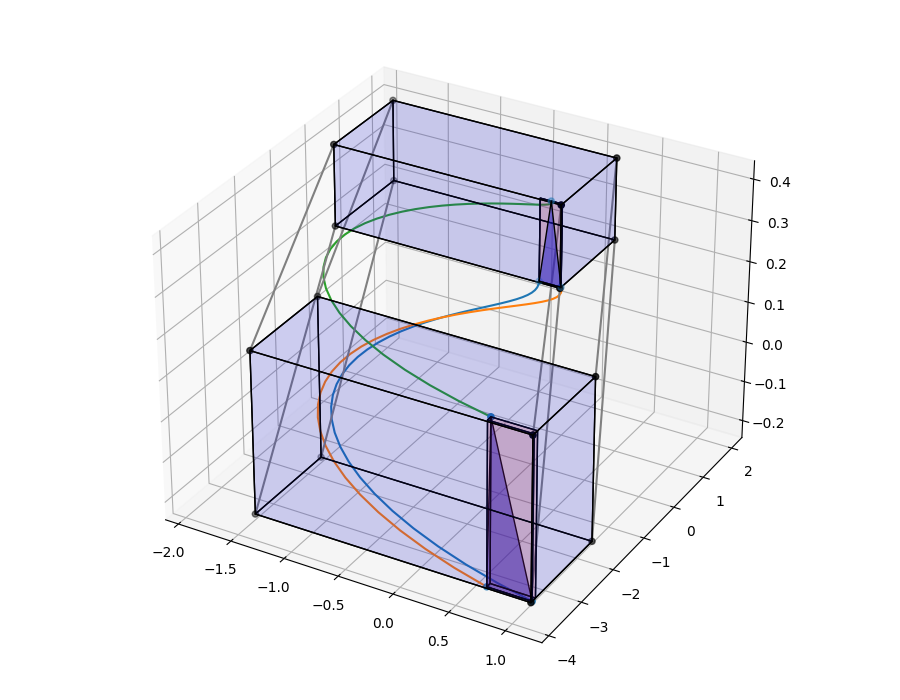

In [17]:
#plotting
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# draw triangle and vertex motions
for i in range(3):
    ax.plot(motion_vertices[i][:,0], motion_vertices[i][:,1], motion_vertices[i][:,2])
ax.scatter3D(tv[:,0], tv[:,1], tv[:,2])
ax.add_collection3d(Poly3DCollection(tf, linewidth=1, edgecolors='black', facecolor=(0.1, 0.1, 0.8, 0.5)))

# draw extended linear bounding box
cbbox0 = bbox0.getCorners()
cbbox1 = bbox1.getCorners()
fbbox0 = getFacesForBBoxCorners(cbbox0)
fbbox1 = getFacesForBBoxCorners(cbbox1)
ax.scatter3D(cbbox0[:,0], cbbox0[:,1], cbbox0[:,2], color='black')
ax.scatter3D(cbbox1[:,0], cbbox1[:,1], cbbox1[:,2], color='black')
ax.add_collection3d(Poly3DCollection(fbbox0, linewidth=1, edgecolors='black', facecolor=(0.1, 0.1, 0.8, 0.1)))
ax.add_collection3d(Poly3DCollection(fbbox1, linewidth=1, edgecolors='black', facecolor=(0.1, 0.1, 0.8, 0.1)))
for i in range(8):
    lbound = np.array([lerp(cbbox0[i], cbbox1[i], t) for t in times]) 
    ax.plot(lbound[:,0], lbound[:,1], lbound[:,2], color='gray')

# draw start/original bounding boxes
bbox0w = BBox()
bbox1w = BBox()
for i in range(3):
    bbox0w.extend(motion(t0[i], t1[i], 0))
    bbox1w.extend(motion(t0[i], t1[i], 1))
fbbox0 = getFacesForBBoxCorners(bbox0w.getCorners())
fbbox1 = getFacesForBBoxCorners(bbox1w.getCorners())
ax.add_collection3d(Poly3DCollection(fbbox0, linewidth=1, edgecolors='black', facecolor=(0.8, 0.1, 0.1, 0.1)))
ax.add_collection3d(Poly3DCollection(fbbox1, linewidth=1, edgecolors='black', facecolor=(0.8, 0.1, 0.1, 0.1)))

plt.tight_layout()
plt.show()

In [18]:
from itertools import product

OK = True
for i, T in product(range(3), np.arange(0, 1, 0.01)):
    P = motion(t0[i], t1[i], T)
    bboxt = lerpBBox(bbox0, bbox1, T)
    if not bboxt.contains(P,1e-4):
        OK = False
if OK:
    print('everying OK!')
else:
    print('error!')

everying OK!
